### Capstone Milestone Report

# Ontario Energy Use: Predicting demand from weather and population data

### * James Parks *

# 1. Introduction - The Problem

It’s clear that weather and population play a huge influence in energy demand and monitoring and energy companies need to be able to anticipate large spikes in demand by playing close attention to the weather. 
In this project we look at the historical hourly energy demand of Ontario, Canada from 1994 until July 2017 along with the historical hourly weather data for Toronto from the same time period.

**The Goal**: Develop a model that predicts energy demand based on weather and population data. 

# The Client

The client in this case is the Ontario Energy Board, which monitors energy usage for the province of Ontario. Having a more robust model for determining just how much changes in weather affect energy demand can be extremely beneficial in saving money and preventing blackouts. Based on this analysis they will be better able to adjust supply to meet expected demands with the changes of seasonal weather. Note that although this data is only for Ontario, the analysis may also be of benefit to other regions with similar weather patterns and populations.

# 2. Imports

In [1]:
#Usual imports
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. The Data

The Data comes from three sources.

- Independent Electricity System Operator, http://www.ieso.ca/power-data which has a .csv file for the hourly energy demand for the province of Ontario from 1994-July 2017.
  
- Environment Canada, which has .csv files for the hourly weather data for many locations in Ontario for the same time period. To start with we choose the data for Toronto, since its urban area accounts for a large percentage of the population of Ontario and make the assumption that its energy demand will contribute to the largest demand in the province.

- Wikipedia, which has the population data for Ontario and Toronto for the years 1996,2001,2006,2011 and 2016. We will use linear interpolation to estimate the approximate population for the intermediate time periods.

## First we import the energy data

In [2]:
#Import the energy data
energy_data_old=pd.read_csv("data\HourlyDemands_1994-2002.csv")
energy_data_recent=pd.read_csv("data\HourlyDemands_2002-2016.csv")
energy_data_this_year=pd.read_csv("data\HourlyDemands.csv")

In [3]:
# Create common columns for all three dataframes
energy_data_old=energy_data_old.rename(columns={'OntarioDemand': 'Ontario Demand'})
energy_data_old['Date']= pd.DatetimeIndex(energy_data_old['DateTime']).date
energy_data_old['Hour']= pd.DatetimeIndex(energy_data_old['DateTime']).hour
energy_data_recent['Date']= pd.DatetimeIndex(energy_data_recent['Date']).date
energy_data_this_year['Date']= pd.DatetimeIndex(energy_data_this_year['Date']).date

In [4]:
# Join all three dataframes together and create a standard datetime column
energy_data_all=pd.concat([energy_data_old,energy_data_recent,energy_data_this_year])
energy_data_all["Date/Time"]=pd.to_datetime(energy_data_all.Date) + energy_data_all.Hour.astype('timedelta64[h]')
# Keep only the Date/Time column and the demand columns
energy_sub = energy_data_all[["Date/Time","Ontario Demand", "Total Market Demand"]]

In [5]:
energy_sub.head(4)

,Date/Time,Ontario Demand,Total Market Demand
0,1994-01-01 00:00:00,14422,NaN
1,1994-01-01 01:00:00,13845,NaN
2,1994-01-01 02:00:00,13372,NaN
3,1994-01-01 03:00:00,13025,NaN


## Import the weather data

In [6]:
# We make a single dataframe from all the csv files in the csv folder
path = "./csv/"
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
weather_data=pd.DataFrame()
for f in files_csv:
    data = pd.read_csv(path+f,skiprows=16)
    weather_data = weather_data.append(data)

In [7]:
weather_data.head(4)

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2002-10-01 00:00,2002,10,1,00:00,,19.5,NaN,16.9,NaN,...,M,NaN,M,100.18,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-10-01 01:00,2002,10,1,01:00,,19.2,NaN,17.2,NaN,...,M,NaN,M,100.19,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-10-01 02:00,2002,10,1,02:00,,19.1,NaN,17.3,NaN,...,M,NaN,M,100.17,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-10-01 03:00,2002,10,1,03:00,,19.2,NaN,17.2,NaN,...,M,NaN,M,100.14,NaN,NaN,NaN,NaN,NaN,NaN


## Import the population data

Note that this data comes from Wikipedia, but only contains population data for the years 1996,2001,2006,2011 and 2016. We will use interpolation to estimate the populations for the years between.

In [8]:
pop_data=pd.read_excel("ontario_pop.xlsx")
# Convert Date column to datetime
pop_data["Date"]=pd.to_datetime(pop_data.Date)
# create a datetime column for the years between 1994 and 2017
date_index = pd.DataFrame({"Date/Time":pd.date_range('1/1/1994', periods=len(weather_data), freq='H')})
# Merge date_index dataframe with the the population data dataframe
pop_merged=date_index.merge(pop_data,left_on="Date/Time",right_on="Date",how="outer")
# Subset on useful columns
pop_merged=pop_merged[["Date/Time", "Ontario_pop","Toronto_pop"]]
# Use linear interpolation to estimate the hourly population between offical census data
pop_merged.interpolate(method='linear',limit_direction="both",inplace=True)
# Round population estimates to the nearest integer
pop_merged[["Ontario_pop","Toronto_pop"]]=pop_merged[["Ontario_pop","Toronto_pop"]].round()

In [9]:
# We merge the energy and weather dataframes together
weather_data["Date/Time"]=pd.to_datetime(weather_data["Date/Time"])
weather_merge=pd.merge(weather_data,energy_sub, how="outer",left_on="Date/Time",right_on="Date/Time")
# Now merge with the populaton dataframes
all_data=pd.merge(weather_merge,pop_merged, how="outer",left_on="Date/Time",right_on="Date/Time")

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207456 entries, 0 to 207455
Data columns (total 29 columns):
Date/Time              207456 non-null datetime64[ns]
Year                   207456 non-null int64
Month                  207456 non-null int64
Day                    207456 non-null int64
Time                   207456 non-null object
Data Quality           204634 non-null object
Temp (°C)              204624 non-null float64
Temp Flag              10 non-null object
Dew Point Temp (°C)    204624 non-null float64
Dew Point Temp Flag    10 non-null object
Rel Hum (%)            204624 non-null float64
Rel Hum Flag           10 non-null object
Wind Dir (10s deg)     69305 non-null float64
Wind Dir Flag          129907 non-null object
Wind Spd (km/h)        75005 non-null float64
Wind Spd Flag          129958 non-null object
Visibility (km)        73619 non-null float64
Visibility Flag        21006 non-null object
Stn Press (kPa)        198969 non-null float64
Stn Press Flag     

# 4. Exploratory Data Analysis

### Investigate monthly temperature average

In [11]:
yearly_avg=all_data.groupby(["Year","Month"]).mean().reset_index()
yearly_avg["year/month"]=pd.to_datetime(yearly_avg[["Year","Month","Day"]])

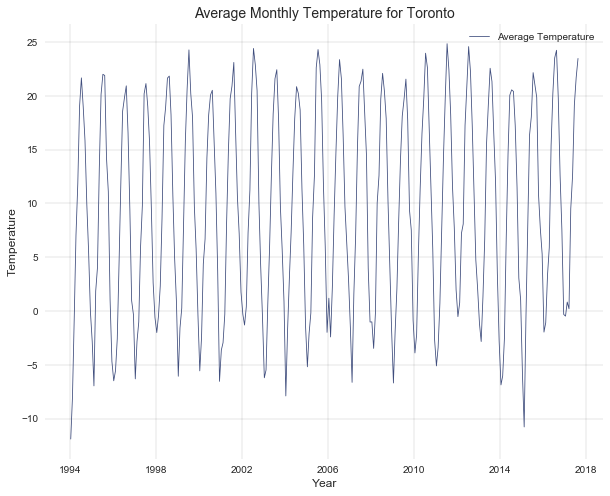

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
ax.grid(color='black', linestyle='-', linewidth=.1)
plt.plot(yearly_avg["year/month"], yearly_avg["Temp (°C)"], color="#3F4D7D", linewidth=0.8,label="Average Temperature")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.title('Average Monthly Temperature for Toronto', fontsize=14)
plt.legend()
plt.show()

** Here we see that monthly average temperatures have not changed too dramatically over the years. The winters of 2014 and especially 2015 look to be outliers in the recent trend of warmer winters of the past six years. **

### Investigate monthly energy demand

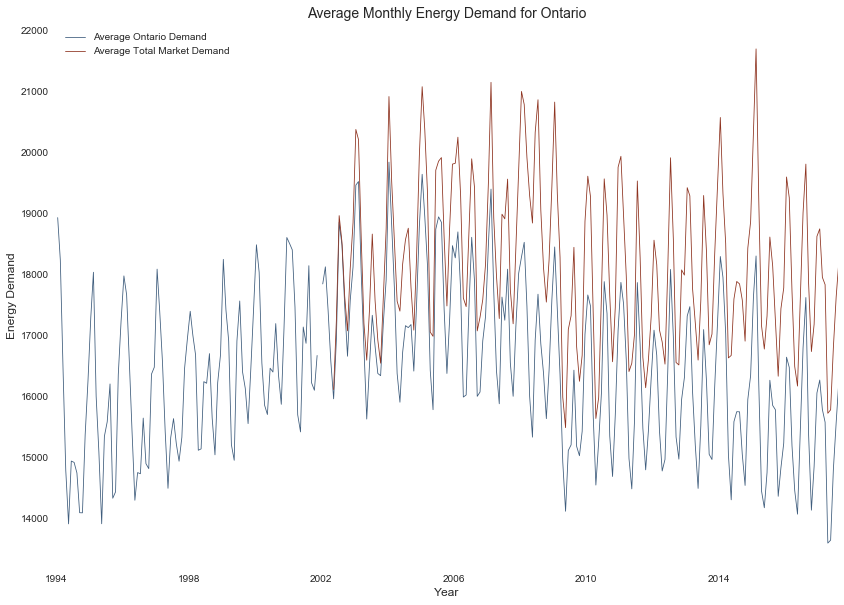

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(yearly_avg["year/month"], yearly_avg["Ontario Demand"], color="#3F5D7D", linewidth=0.8,label="Average Ontario Demand")
plt.plot(yearly_avg["year/month"], yearly_avg["Total Market Demand"], color="#8E3320", linewidth=0.8,label="Average Total Market Demand")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Energy Demand', fontsize=12)
plt.title('Average Monthly Energy Demand for Ontario', fontsize=14)
plt.xlim(["1994-01-01","2017-07-31"])
plt.legend()
plt.show()

** There's something weird with the drop in energy demand after 2003. The drop in 2009 could also be a result of the recession? It looks like that the spike in energy demand is for the winter of 2015. **

Here we are going to explain what has been happening with demand and what the difference between total market vs ontario and which parts are sold and how it is measured.

In [42]:
all_data.describe()

,Year,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Ontario Demand,Total Market Demand,Ontario_pop,Toronto_pop
count,207456.000000,207456.000000,207456.000000,204624.000000,204624.000000,204624.000000,69305.000000,75005.000000,73619.000000,198969.000000,32588.000000,0.0,16589.000000,0.0,206088.000000,133824.000000,2.074560e+05,2.074560e+05
mean,2005.338038,6.466682,15.729292,9.313238,3.771429,70.503651,22.444499,14.913232,21.264546,99.961146,29.865748,NaN,-11.868346,NaN,16446.464234,18205.337697,1.210313e+07,5.533069e+06
std,6.833718,3.437515,8.800016,10.668125,10.207141,16.412864,9.895402,9.836360,9.570469,0.842791,3.812768,NaN,6.391140,NaN,2568.770562,2531.071000,9.342699e+05,6.227322e+05
min,1994.000000,1.000000,1.000000,-30.300000,-36.100000,9.000000,1.000000,0.000000,0.000000,96.550000,25.000000,NaN,-40.000000,NaN,2270.000000,2270.000000,1.049127e+07,4.447904e+06
25%,1999.000000,3.000000,8.000000,1.200000,-3.600000,60.000000,14.000000,7.000000,16.100000,99.420000,27.000000,NaN,-16.000000,NaN,14522.000000,16317.000000,1.126775e+07,4.983648e+06
50%,2005.000000,6.000000,16.000000,9.400000,3.900000,72.000000,25.000000,13.000000,24.100000,99.980000,29.000000,NaN,-11.000000,NaN,16433.000000,18128.000000,1.213521e+07,5.540070e+06
75%,2011.000000,9.000000,23.000000,18.200000,12.300000,83.000000,31.000000,20.000000,25.000000,100.520000,32.000000,NaN,-7.000000,NaN,18230.000000,19890.000000,1.294134e+07,6.108703e+06
max,2017.000000,12.000000,31.000000,37.400000,26.700000,100.000000,36.000000,76.000000,40.200000,102.980000,51.000000,NaN,-1.000000,NaN,27005.000000,27999.000000,1.364728e+07,6.538558e+06


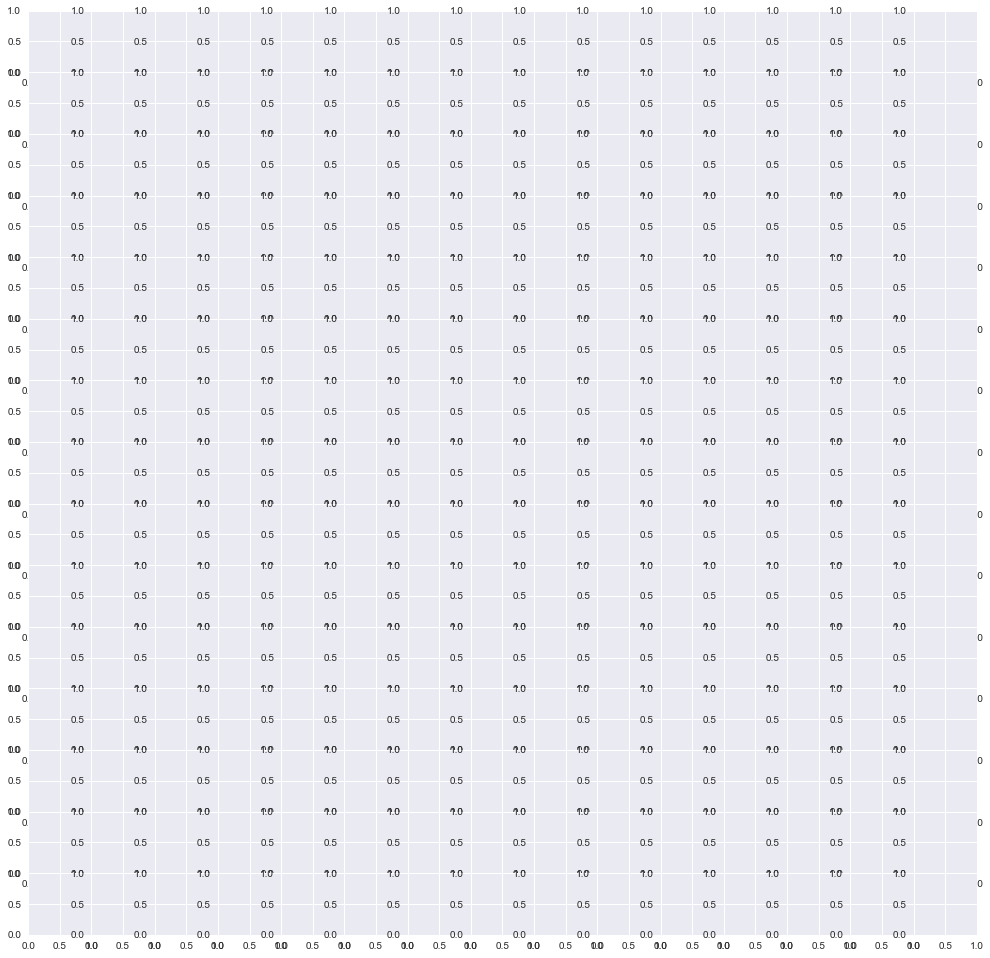

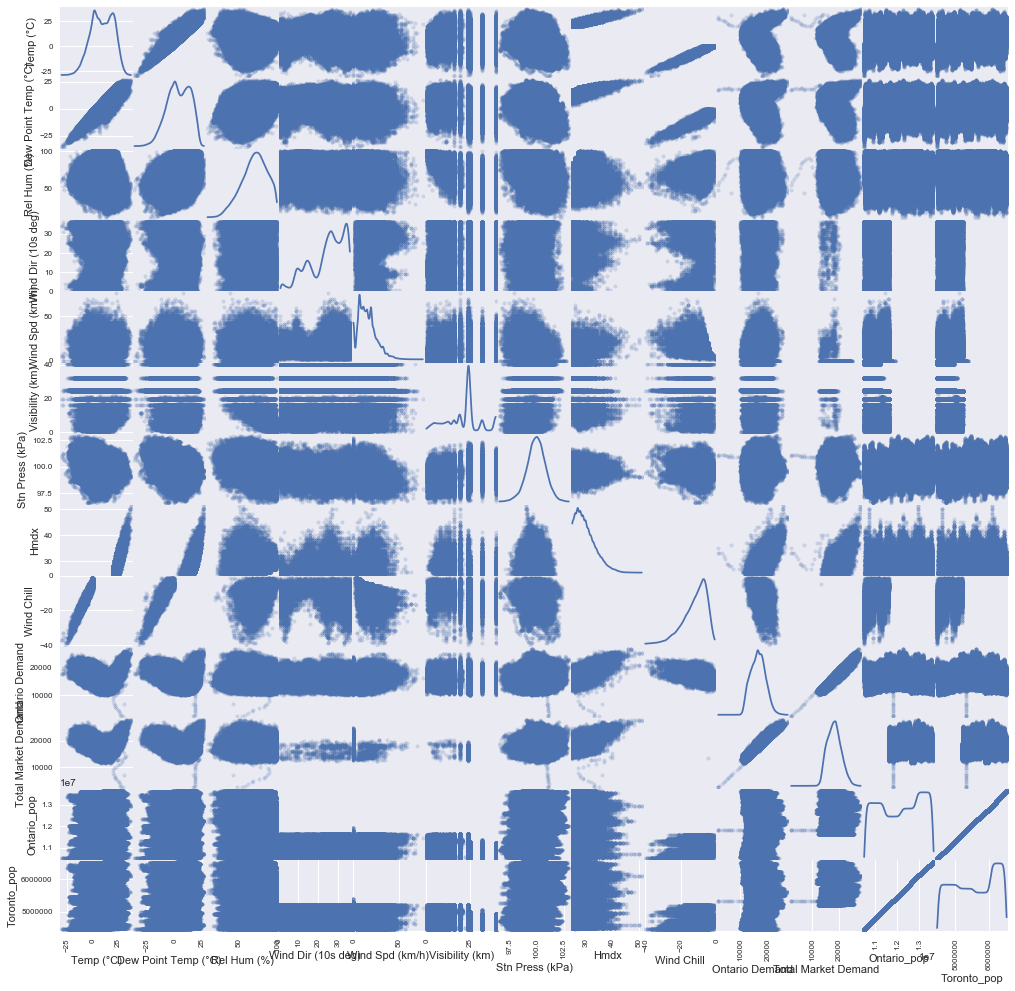

In [44]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(all_data.drop(["Year","Month","Day","Hmdx Flag","Wind Chill Flag"],axis=1),alpha=0.2, figsize=(17, 17), diagonal='kde')
plt.show()

** Most of the variables are normally distributed. We see some suspicious outliers in the energy demand vs temperature and energy demand vs humidex scatter plots. Otherwise there is a very strong correlation between humidex and energy demand and energy demand and a non-linear relationship between temperature and energy demand. The non-linear nature is due to the large demand for heat when the temperature is very low and the large demand for cooling when the temperature is very high. **

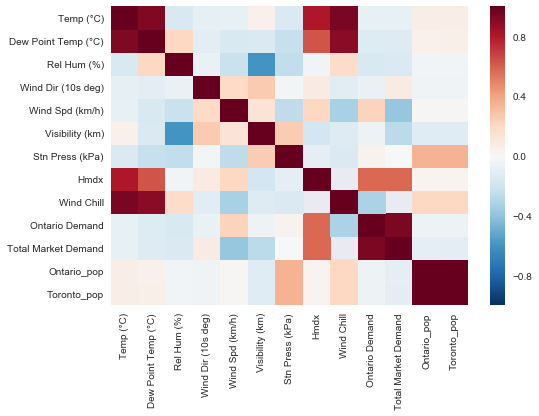

In [45]:
corr = all_data.drop(["Year","Month","Day","Hmdx Flag","Wind Chill Flag"],axis=1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Here we see a strong positive correlation between humidex and energy demand.

## Investigate outliers

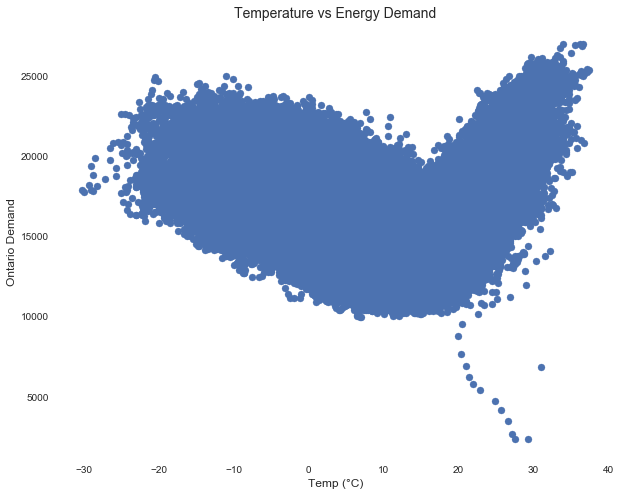

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.scatter(all_data["Temp (°C)"], all_data["Ontario Demand"])
plt.xlabel('Temp (°C)', fontsize=12)
plt.ylabel('Ontario Demand', fontsize=12)
plt.title('Temperature vs Energy Demand', fontsize=14)
plt.show()

There is a very clear distinctive relationship between temperature and energy demand. We see that energy demand increases slowly as temperature decreases from 15°C and increases more rapidly as temperature increases from 15 °C.

In [47]:
low_energy=all_data[all_data["Ontario Demand"]<10000]
low_energy["Date/Time"].unique

<bound method Series.unique of 12760    2003-08-14 16:00:00
12761    2003-08-14 17:00:00
12762    2003-08-14 18:00:00
12763    2003-08-14 19:00:00
12764    2003-08-14 20:00:00
12765    2003-08-14 21:00:00
12766    2003-08-14 22:00:00
12767    2003-08-14 23:00:00
12768    2003-08-15 00:00:00
12769    2003-08-15 01:00:00
12770    2003-08-15 02:00:00
12771    2003-08-15 03:00:00
12772    2003-08-15 04:00:00
12773    2003-08-15 05:00:00
12774    2003-08-15 06:00:00
141843   1994-09-05 03:00:00
141844   1994-09-05 04:00:00
Name: Date/Time, dtype: datetime64[ns]>

On August 14, 2003, Ontario and the northeastern United States experience a large scale blackout. https://en.wikipedia.org/wiki/Northeast_blackout_of_2003 At the time, it was the world's second most widespread blackout in history.

In [20]:
# Let's remove the blackout times from out data since this is something we want to prevent in the model.
#weather_drop=all_data_sub.drop(all_data_sub.index[12760:12784])

## Investigate the relationship between Energy demand with both humidex and temperature.

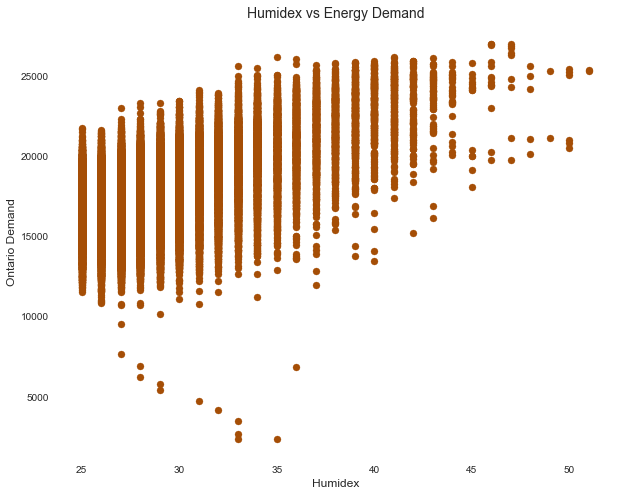

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.scatter(all_data["Hmdx"], all_data["Ontario Demand"],color='#a54e06')
plt.xlabel('Humidex', fontsize=12)
plt.ylabel('Ontario Demand', fontsize=12)
plt.title('Humidex vs Energy Demand', fontsize=14)
plt.show()

Here we see a slight postive relationship between Humidex and Energy demand with quite a few outliers.

# Missing values
Our data is somewhat messy with a lot of missing data. We need to find a way to replace the missing data with 
a reasonable guess.

First we remove the columns that are almost entirely NaN's or have letters signifying missing data.

In [49]:
missing_columns=["Data Quality","Temp Flag","Dew Point Temp Flag","Rel Hum Flag","Wind Dir Flag", "Wind Spd Flag",
                 "Visibility Flag","Stn Press Flag","Hmdx Flag","Wind Chill Flag"]
df_sub=all_data.drop(missing_columns,axis=1)

We first remove the info past July 31, 2017 (This will be until August 31 in the future).

In [137]:
df_sub_noaug=df_sub[df_sub["Date/Time"]<"2017-08-01"]
df_sub_noaug.sort_values(by="Date/Time").tail(5)

,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Ontario Demand,Total Market Demand,Ontario_pop,Toronto_pop
132955,2017-07-31 19:00:00,2017,7,31,19:00,24.9,16.7,60.0,NaN,NaN,NaN,100.42,30.0,NaN,NaN,19855.0,21544.0,13637400.0,6532544.0
132956,2017-07-31 20:00:00,2017,7,31,20:00,24.0,17.0,65.0,NaN,NaN,NaN,100.44,29.0,NaN,NaN,19654.0,21418.0,13637413.0,6532552.0
132957,2017-07-31 21:00:00,2017,7,31,21:00,23.0,17.1,69.0,NaN,NaN,NaN,100.50,28.0,NaN,NaN,19696.0,21468.0,13637427.0,6532561.0
132958,2017-07-31 22:00:00,2017,7,31,22:00,23.8,17.4,67.0,NaN,NaN,NaN,100.47,29.0,NaN,NaN,18643.0,20297.0,13637440.0,6532569.0
132959,2017-07-31 23:00:00,2017,7,31,23:00,23.0,17.1,70.0,NaN,NaN,NaN,100.47,28.0,NaN,NaN,16949.0,18782.0,13637454.0,6532577.0


We first use linear interpolation for the "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Stn Press (kPa)", "Ontario Demand" and "Total Market Demand" columns when there is only one hour's worth of data is missing.

In [138]:
df_sub_noaug=df_sub_noaug.sort_values(by="Date/Time").reset_index().drop("index",axis=1)
df_sub_noaug.interpolate(method='linear',limit_direction="forward",limit=1,inplace=True)

When there is more than one hour's worth of missing data we use the previous day's data for the "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Stn Press (kPa)", "Ontario Demand" and "Total Market Demand" columns.

In [139]:
df_sub_noaug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206712 entries, 0 to 206711
Data columns (total 19 columns):
Date/Time              206712 non-null datetime64[ns]
Year                   206712 non-null int64
Month                  206712 non-null int64
Day                    206712 non-null int64
Time                   206712 non-null object
Temp (°C)              205704 non-null float64
Dew Point Temp (°C)    205704 non-null float64
Rel Hum (%)            205704 non-null float64
Wind Dir (10s deg)     71816 non-null float64
Wind Spd (km/h)        75249 non-null float64
Visibility (km)        73722 non-null float64
Stn Press (kPa)        200052 non-null float64
Hmdx                   34966 non-null float64
Wind Chill             17605 non-null float64
Weather                73616 non-null object
Ontario Demand         205969 non-null float64
Total Market Demand    133703 non-null float64
Ontario_pop            206712 non-null float64
Toronto_pop            206712 non-null float64
dty

In [140]:
#df_sub_noaug=df_sub_noaug.sort_values(by="Date/Time").reset_index().drop("index",axis=1)
index_list_temp=df_sub_noaug[df_sub_noaug["Temp (°C)"].isnull()].index
for i in index_list_temp:
    df_sub_noaug.iloc[i,5]=df_sub_noaug.iloc[i-24,5]
    df_sub_noaug.iloc[i,6]=df_sub_noaug.iloc[i-24,6]
    df_sub_noaug.iloc[i,7]=df_sub_noaug.iloc[i-24,7]
#index_list_hum=df_sub_noaug[df_sub_noaug["Rel Hum (%)"].isnull()].index
#for i in index_list_hum:
index_list_stn=df_sub_noaug[df_sub_noaug["Stn Press (kPa)"].isnull()].index
for i in index_list_stn:
    df_sub_noaug.iloc[i,11]=df_sub_noaug.iloc[i-24,11]
index_list_ont=df_sub_noaug[df_sub_noaug["Ontario Demand"].isnull()].index
for i in index_list_ont:
    df_sub_noaug.iloc[i,15]=df_sub_noaug.iloc[i-24,15]

We have the following formula for Humidex.
Humidex $${\text{Humidex}}=T_{\text{air}}+0.5555\left[6.11e^{5417.7530\left({\frac {1}{273.16}}-{\frac {1}{273.15+T_{\text{dew}}}}\right)}-10\right]$$
We should look into formulas for wind chill, what to do with no wind given, station pressure, should we interpolate the missing ontario demands and temperatures.

In [141]:
index_list_hmdx=df_sub_noaug[df_sub_noaug["Hmdx"].isnull()].index
for i in index_list_hmdx:
    df_sub_noaug.iloc[i,12]=df_sub_noaug.iloc[i,5]+0.5555*(6.11*np.exp(5417.7530*(1/273.16-1/(273.15+df_sub_noaug.iloc[i,5])))-10).round(decimals=1)

In [142]:
df_sub_noaug.head(10)

,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Ontario Demand,Total Market Demand,Ontario_pop,Toronto_pop
0,1994-01-01 00:00:00,1994,1,1,00:00,-1.2,-3.8,83.0,20.0,15.0,19.3,99.91,-3.64420,-6.000000,Cloudy,14422.0,NaN,10491271.0,4447904.0
1,1994-01-01 01:00:00,1994,1,1,01:00,-0.9,-3.0,86.0,22.0,20.0,16.1,99.91,-3.28865,-6.000000,Cloudy,13845.0,NaN,10491286.0,4447914.0
2,1994-01-01 02:00:00,1994,1,1,02:00,-0.7,-3.2,83.0,22.0,15.0,16.1,99.87,-3.03310,-5.000000,Cloudy,13372.0,NaN,10491301.0,4447925.0
3,1994-01-01 03:00:00,1994,1,1,03:00,-0.8,-2.4,89.0,20.0,15.0,12.9,99.81,-3.13310,-5.000000,Cloudy,13025.0,NaN,10491316.0,4447935.0
4,1994-01-01 04:00:00,1994,1,1,04:00,-1.0,-3.3,84.0,20.0,19.0,16.1,99.77,-3.38865,-6.000000,Mostly Cloudy,12869.0,NaN,10491331.0,4447945.0
5,1994-01-01 05:00:00,1994,1,1,05:00,-1.8,-3.6,87.0,19.0,11.0,16.1,99.67,-4.35530,-6.000000,Cloudy,12866.0,NaN,10491346.0,4447956.0
6,1994-01-01 06:00:00,1994,1,1,06:00,-1.7,-3.9,85.0,19.0,15.0,19.3,99.57,-4.25530,-7.000000,Cloudy,13015.0,NaN,10491361.0,4447966.0
7,1994-01-01 07:00:00,1994,1,1,07:00,-1.8,-4.8,80.0,15.0,15.0,16.1,99.37,-4.35530,-7.000000,Mostly Cloudy,13577.0,NaN,10491376.0,4447976.0
8,1994-01-01 08:00:00,1994,1,1,08:00,-0.5,-3.8,78.0,18.0,17.0,25.0,99.31,-2.77755,-5.000000,Mostly Cloudy,13567.0,NaN,10491391.0,4447987.0
9,1994-01-01 09:00:00,1994,1,1,09:00,0.5,-3.7,73.0,19.0,24.0,25.0,99.14,-1.55535,-5.055556,Mostly Cloudy,14130.0,NaN,10491406.0,4447997.0


In [143]:
df_sub_noaug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206712 entries, 0 to 206711
Data columns (total 19 columns):
Date/Time              206712 non-null datetime64[ns]
Year                   206712 non-null int64
Month                  206712 non-null int64
Day                    206712 non-null int64
Time                   206712 non-null object
Temp (°C)              206712 non-null float64
Dew Point Temp (°C)    206712 non-null float64
Rel Hum (%)            206712 non-null float64
Wind Dir (10s deg)     71816 non-null float64
Wind Spd (km/h)        75249 non-null float64
Visibility (km)        73722 non-null float64
Stn Press (kPa)        206712 non-null float64
Hmdx                   206712 non-null float64
Wind Chill             17605 non-null float64
Weather                73616 non-null object
Ontario Demand         206712 non-null float64
Total Market Demand    133703 non-null float64
Ontario_pop            206712 non-null float64
Toronto_pop            206712 non-null float64
dt

In [144]:
def line_plot(df,ind,dep):
    fig,ax = plt.subplots(figsize=(12,9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.plot(df[ind], df[dep], color="#3F4D7D", linewidth=0.8,label="Average " + dep)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(ind + " vs Average " + dep, fontsize=14)
    plt.legend()
    plt.show()

## Average hourly consumption

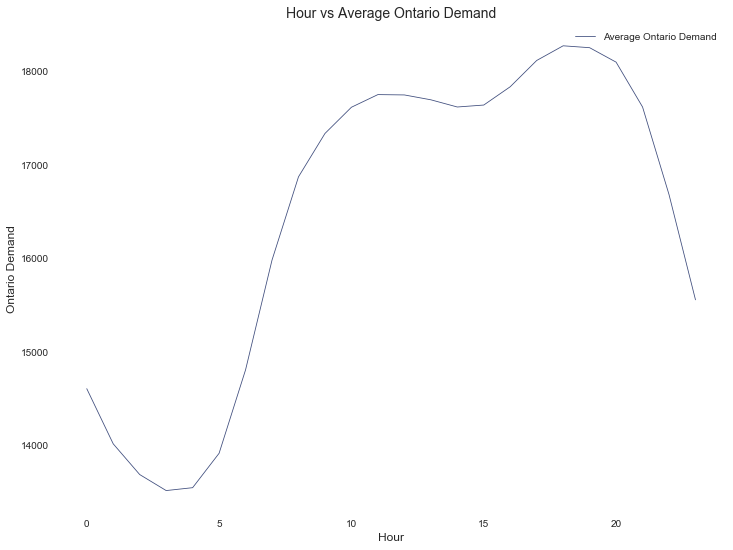

In [145]:
# Let's look at average hourly consumption. 
hourly_avg=weather_merge.groupby(["Time"]).mean().reset_index()
hourly_avg["Hour"]=pd.to_datetime(hourly_avg["Time"], format='%H:%M').dt.hour
line_plot(hourly_avg,"Hour","Ontario Demand")

Here we see that the demand is lowest on average between 2 and 5 a.m. and then increases rapidly between 5 and 10 as people wake up and go to work. There is a slight decrease from 11 until 3 and then a bigger spike between 16 and 20 when people are generally back at home.

## Look at the spikes in demand, what can we say about what was happening before? 

In addition, look into when the biggest changes occur between hourly energy consumption

In [25]:
weather_drop["demand_diff"] = weather_drop["Ontario Demand"].diff()
weather_drop["temp_diff"] = weather_drop["Temp (°C)"].diff()
#weather_drop["absolute_temp_diff"]=weather_drop["temp_diff"].abs()

In [26]:
weather_drop.sort_values(by="demand_diff",ascending=False).head(10)

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,...,Stn Press Flag,Hmdx,Wind Chill,Weather,Ontario Demand,Total Market Demand,Ontario_pop,Toronto_pop,demand_diff,temp_diff
126639,2016-08-10 15:00:00,2016,8,10,15:00,,32.4,NaN,17.7,NaN,...,NaN,38.0,NaN,NaN,22587.0,23488.0,13521280.0,6461837.0,3942.0,-0.5
195072,2001-01-01 00:00:00,2001,1,1,00:00,,-8.5,NaN,-11.3,NaN,...,NaN,NaN,-15.0,Mainly Clear,16434.0,NaN,11410046.0,5081826.0,3463.0,-20.3
136656,1994-02-01 00:00:00,1994,2,1,00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17843.0,NaN,10502410.0,4455589.0,3265.0,NaN
168768,1998-01-01 00:00:00,1998,1,1,00:00,,-14.4,NaN,-18.0,NaN,...,NaN,NaN,-17.0,Clear,16277.0,NaN,11016234.0,4810110.0,3088.0,-23.2
78216,2011-02-01 00:00:00,2011,2,1,00:00,,-10.7,NaN,-18.5,NaN,...,NaN,NaN,NaN,NaN,17826.0,19658.0,12861951.0,6060359.0,2854.0,-14.0
32144,2006-01-30 08:00:00,2006,1,30,08:00,,5.7,NaN,4.4,NaN,...,NaN,NaN,NaN,NaN,18895.0,19438.0,12171391.0,5563916.0,2831.0,-0.8
160008,1997-01-01 00:00:00,1997,1,1,00:00,,-14.3,NaN,-16.7,NaN,...,NaN,NaN,-23.0,Snow Showers,15681.0,NaN,10885083.0,4719620.0,2762.0,-27.7
177528,1999-01-01 00:00:00,1999,1,1,00:00,,-9.3,NaN,-12.7,NaN,...,NaN,NaN,-18.0,Clear,16145.0,NaN,11147385.0,4900599.0,2600.0,-25.3
15559,2004-11-08 07:00:00,2004,11,8,07:00,,1.4,NaN,-3.4,NaN,...,NaN,NaN,NaN,NaN,16501.0,17608.0,11988250.0,5447202.0,2371.0,-0.4
43152,2007-02-01 00:00:00,2007,2,1,00:00,,-6.3,NaN,-10.7,NaN,...,NaN,NaN,NaN,NaN,18334.0,19127.0,12310254.0,5663973.0,2350.0,-6.7


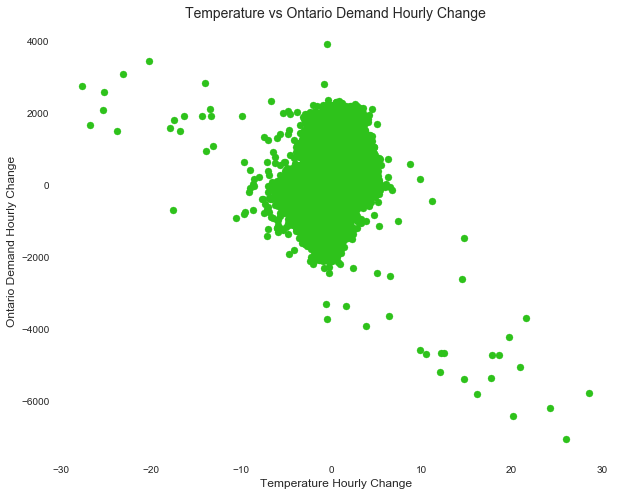

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.scatter(weather_drop.temp_diff,weather_drop.demand_diff,color='#2ec21b')
plt.xlabel('Temperature Hourly Change', fontsize=12)
plt.ylabel('Ontario Demand Hourly Change', fontsize=12)
plt.title('Temperature vs Ontario Demand Hourly Change', fontsize=14)
plt.show()

There seems to be some interesting very high spikes in energy demand when the temperature decreases rapidly. Conversely, when the weather warms rapidly there is significant decrease in the energy demand. 

## Look into when there is a weather flag. How is energy demand different during those hours?

In [28]:
print(weather_drop[weather_drop.Weather.notnull()].mean())

Year                   1.997724e+03
Month                  6.350101e+00
Day                    1.572813e+01
Temp (°C)              8.327866e+00
Dew Point Temp (°C)    2.736361e+00
Rel Hum (%)            7.012416e+01
Wind Dir (10s deg)     2.244433e+01
Wind Spd (km/h)        1.519424e+01
Visibility (km)        2.126428e+01
Stn Press (kPa)        9.952427e+01
Hmdx                   2.942550e+01
Wind Chill            -1.186774e+01
Ontario Demand         1.626193e+04
Total Market Demand    1.611609e+04
Ontario_pop            1.104593e+07
Toronto_pop            4.829562e+06
demand_diff            1.156886e-02
temp_diff              3.033518e-04
dtype: float64


In [29]:
weather_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207432 entries, 0 to 207455
Data columns (total 29 columns):
Date/Time              207432 non-null datetime64[ns]
Year                   207432 non-null int64
Month                  207432 non-null int64
Day                    207432 non-null int64
Time                   207432 non-null object
Data Quality           204612 non-null object
Temp (°C)              204602 non-null float64
Temp Flag              10 non-null object
Dew Point Temp (°C)    204602 non-null float64
Dew Point Temp Flag    10 non-null object
Rel Hum (%)            204602 non-null float64
Rel Hum Flag           10 non-null object
Wind Dir (10s deg)     69305 non-null float64
Wind Dir Flag          129885 non-null object
Wind Spd (km/h)        75005 non-null float64
Wind Spd Flag          129936 non-null object
Visibility (km)        73619 non-null float64
Visibility Flag        20984 non-null object
Stn Press (kPa)        198947 non-null float64
Stn Press Flag     

When there is a weather flag it seems like there is slightly less energy demand.

## Rolling averages


## Look into big changes in temperature from mean for that day 

# Machine Learning Section

In [146]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [161]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
array = df_ml.values
X=array[:,1:8]
y=array[:,8]
seed=7
model = LinearRegression()
#parameters={}

kfold = KFold(n_splits=10, random_state=seed)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
#GridSearchCV(model, parameters, cv = 5, scoring = 'neg_mean_absolute_error')
scoring = ['neg_mean_absolute_error','neg_mean_squared_error','r2' ]
for s in scoring:
    results = cross_val_score(model, X, y, cv=kfold, scoring=s)
    print(s, "mean", results.mean(), "std", results.std())

neg_mean_absolute_error mean -2159.20287829 std 270.896016904
neg_mean_squared_error mean -7091140.33972 std 1696278.76124
r2 mean -0.173136366757 std 0.314893576986


In [ ]:

'neg_mean_squared_error'



In [147]:
def do_regression(clf, parameters, indf, featurenames, targetname, target1val, standardize=False,seed = 7):
    #To create the 'X' dataset we first standardize by the mean and standard deviation is standardize is set to True
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    #Create the 'X' and 'y' datasets
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    # Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
    clf = clf()
    # Now implement GridSearchCV for the cross validation step 
    grid_clf = GridSearchCV(clf, parameters, cv = 5, scoring = 'neg_mean_absolute_error')
    # Use the classifier to fit the training data
    grid_clf.fit(Xtrain, ytrain)
    grid_est=grid_clf.best_estimator_
    print("BEST PARAMS", grid_clf.best_params_)
    clf_model = grid_est.fit(Xtrain, ytrain)
    predicted=clf_model.predict_proba(Xtest)[:,1]
    return clf_model

In [ ]:
    for train_index, test_index in sss.split(X,y):
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        #Now implement GridSearchCV for the cross validation step 
        clf = cv_optimize(clf, parameters, Xtrain, ytrain)
        #Use the classifier to fit the training data
        clf=clf.fit(Xtrain, ytrain)
        training_accuracy = clf.score(Xtrain, ytrain)
        test_accuracy = clf.score(Xtest, ytest)
        print("Accuracy on training data: {:0.5f}".format(training_accuracy))
        print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
        test_prediction=clf.predict(Xtest)
        print(confusion_matrix(ytest,test_prediction))
        print(classification_report(ytest,test_prediction))
    return clf, Xtrain, ytrain, Xtest, ytest

In [148]:
df_sub_noaug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206712 entries, 0 to 206711
Data columns (total 19 columns):
Date/Time              206712 non-null datetime64[ns]
Year                   206712 non-null int64
Month                  206712 non-null int64
Day                    206712 non-null int64
Time                   206712 non-null object
Temp (°C)              206712 non-null float64
Dew Point Temp (°C)    206712 non-null float64
Rel Hum (%)            206712 non-null float64
Wind Dir (10s deg)     71816 non-null float64
Wind Spd (km/h)        75249 non-null float64
Visibility (km)        73722 non-null float64
Stn Press (kPa)        206712 non-null float64
Hmdx                   206712 non-null float64
Wind Chill             17605 non-null float64
Weather                73616 non-null object
Ontario Demand         206712 non-null float64
Total Market Demand    133703 non-null float64
Ontario_pop            206712 non-null float64
Toronto_pop            206712 non-null float64
dt

In [149]:
linear_feature_cols=["Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)","Stn Press (kPa)","Hmdx","Ontario_pop","Toronto_pop"]

In [152]:
df_ml=df_sub_noaug[["Date/Time","Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)","Stn Press (kPa)","Hmdx","Ontario_pop","Toronto_pop","Ontario Demand"]]
df_ml.head(10)

,Date/Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Stn Press (kPa),Hmdx,Ontario_pop,Toronto_pop,Ontario Demand
0,1994-01-01 00:00:00,-1.2,-3.8,83.0,99.91,-3.64420,10491271.0,4447904.0,14422.0
1,1994-01-01 01:00:00,-0.9,-3.0,86.0,99.91,-3.28865,10491286.0,4447914.0,13845.0
2,1994-01-01 02:00:00,-0.7,-3.2,83.0,99.87,-3.03310,10491301.0,4447925.0,13372.0
3,1994-01-01 03:00:00,-0.8,-2.4,89.0,99.81,-3.13310,10491316.0,4447935.0,13025.0
4,1994-01-01 04:00:00,-1.0,-3.3,84.0,99.77,-3.38865,10491331.0,4447945.0,12869.0
5,1994-01-01 05:00:00,-1.8,-3.6,87.0,99.67,-4.35530,10491346.0,4447956.0,12866.0
6,1994-01-01 06:00:00,-1.7,-3.9,85.0,99.57,-4.25530,10491361.0,4447966.0,13015.0
7,1994-01-01 07:00:00,-1.8,-4.8,80.0,99.37,-4.35530,10491376.0,4447976.0,13577.0
8,1994-01-01 08:00:00,-0.5,-3.8,78.0,99.31,-2.77755,10491391.0,4447987.0,13567.0
9,1994-01-01 09:00:00,0.5,-3.7,73.0,99.14,-1.55535,10491406.0,4447997.0,14130.0


In [153]:
from sklearn.ensemble import RandomForestRegressor
params={'n_estimators':[500,1000],'max_depth':[5]}
clf_rf= do_regression(RandomForestRegressor, params, df_ml, linear_feature_cols, 'Ontario Demand',1)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [60]:
linear_feature_cols = weather_drop.drop(["Date/Time","Time", "Data Quality","Temp Flag","Dew Point Temp Flag",
"Rel Hum Flag","Wind Dir Flag","Wind Spd Flag","Visibility Flag","Stn Press Flag","Weather",
 "demand_diff","temp_diff","Ontario Demand","Total Market Demand"],axis=1).columns
from sklearn.linear_model import LinearRegression
#params = {"C": [0.001, 0.1, 1, 10, 100]}
clf_linear= do_regression(LinearRegression, {}, weather_drop, linear_feature_cols, "Ontario Demand",1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [59]:

weather_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207432 entries, 0 to 207455
Data columns (total 29 columns):
Date/Time              207432 non-null datetime64[ns]
Year                   207432 non-null int64
Month                  207432 non-null int64
Day                    207432 non-null int64
Time                   207432 non-null object
Data Quality           204612 non-null object
Temp (°C)              204602 non-null float64
Temp Flag              10 non-null object
Dew Point Temp (°C)    204602 non-null float64
Dew Point Temp Flag    10 non-null object
Rel Hum (%)            204602 non-null float64
Rel Hum Flag           10 non-null object
Wind Dir (10s deg)     69305 non-null float64
Wind Dir Flag          129885 non-null object
Wind Spd (km/h)        75005 non-null float64
Wind Spd Flag          129936 non-null object
Visibility (km)        73619 non-null float64
Visibility Flag        20984 non-null object
Stn Press (kPa)        198947 non-null float64
Stn Press Flag     

In [38]:
energy_price=pd.read_csv("HOEP_2002-2016.csv")
energy_price["Date/Time"]=pd.to_datetime(energy_price.Date) + energy_price.Hour.astype('timedelta64[h]')
energy_price.head(10)

,Date,Hour,HOEP,Date/Time
0,01-May-02,1,22.97,2002-05-01 01:00:00
1,01-May-02,2,23.27,2002-05-01 02:00:00
2,01-May-02,3,24.54,2002-05-01 03:00:00
3,01-May-02,4,15.17,2002-05-01 04:00:00
4,01-May-02,5,23.59,2002-05-01 05:00:00
5,01-May-02,6,28.84,2002-05-01 06:00:00
6,01-May-02,7,30.63,2002-05-01 07:00:00
7,01-May-02,8,32.23,2002-05-01 08:00:00
8,01-May-02,9,30.00,2002-05-01 09:00:00
9,01-May-02,10,30.16,2002-05-01 10:00:00


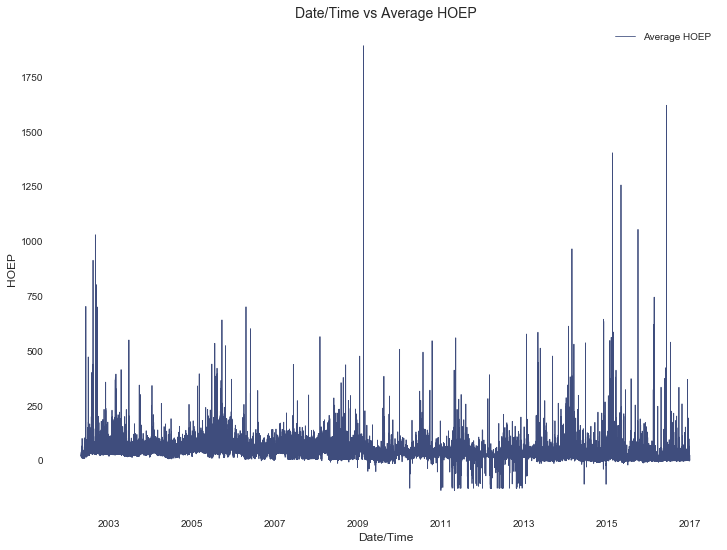

In [39]:
line_plot(energy_price,"Date/Time","HOEP")

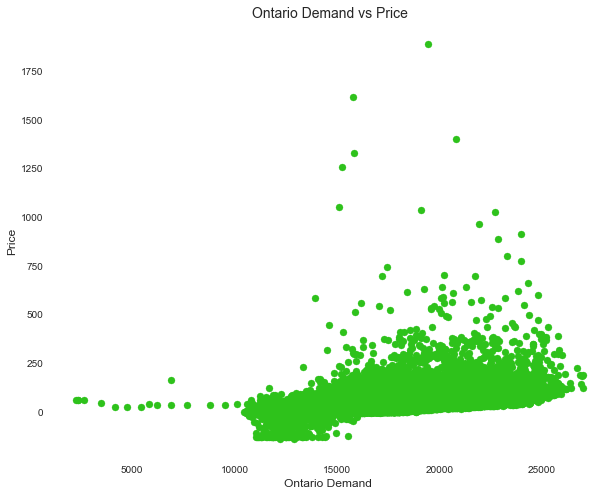

In [41]:
energy_merge=energy_price.merge(all_data_sub,left_on="Date/Time",right_on="Date/Time")
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.scatter(energy_merge["Ontario Demand"],energy_merge.HOEP,color='#2ec21b')
plt.ylabel('Price', fontsize=12)
plt.xlabel('Ontario Demand ', fontsize=12)
plt.title('Ontario Demand vs Price', fontsize=14)
plt.show()